### QC+ for Cai 2020 dataset

#### Objective: Run advanced QC for the Cai 2020 dataset, including data normalization, log transformation, and UMAP visualization


**Developed by**: Mairi McClean

**Affiliation**: Computational Health Centre - Helmholtz Munich

**v221130**


### Load modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
igraph              0.10.2
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso       

### Read in anndata object

In [3]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qcd_objects/2111_2511_exported_objects/23/CaiY2022_TB_QCed_pre-process_mm221123.h5ad')
adata

AnnData object with n_obs × n_vars = 66560 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

### Data normalization

In [4]:
# target_sum taken from Scanpy tutorial [https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

#If exclude_highly_expressed=True, very highly expressed genes are excluded from the computation of the normalization factor (size factor) for each cell. 
#This is meaningful as these can strongly influence the resulting normalized values for all other genes [Weinreb17]."

#1e4 changed to 1e6; option to exclude highly expressed genes, set as true - CHANGE THIS FIRST

sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


### Data log transformation

In [5]:
sc.pp.log1p(adata)

### Identify highly variable genes

In [6]:
# Code from Carlos' notebook scVI_exploratory_analysis; Seurat should be used for all generative models
# number of genes (top_genes) based on how mixed the sample is, and computational power. Highest gene number is 10,000
# batch_key is related to the data that we want to perform the filtering on
# Carlos runs between 4000 (low RAM) and 7000
#subset = True will remove all non-variable genes

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [7]:
adata.var


,gene_id,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
DDX11L1,ENSG00000223972.5,False,False,8,0.000135,99.987981,9.0,True,601.5,0.000954,0.007616,0.461496,2
OR4G11P,ENSG00000240361.2,False,False,4,0.000075,99.993990,5.0,True,2435.0,0.000481,0.003861,0.188855,2
ENSG00000286448,ENSG00000286448.1,False,False,12,0.000180,99.981971,12.0,True,832.0,0.001417,0.011175,0.557035,2
ENSG00000230021,ENSG00000230021.10,False,False,14932,0.282091,77.566106,18776.0,True,162.0,1.771820,10.924513,1.153774,9
ENSG00000278791,ENSG00000278791.1,False,False,6530,0.110081,90.189303,7327.0,True,2447.0,0.766505,5.430839,1.048885,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907.2,True,False,5740,0.120207,91.376202,8001.0,True,2129.5,0.677038,4.894911,1.034984,4
MT-ND4,ENSG00000198886.2,True,False,25261,0.777915,62.047776,51778.0,True,23.0,3.116366,16.029165,1.448012,11
MT-ND5,ENSG00000198786.2,True,False,37375,1.608834,43.847656,107084.0,True,11.0,4.779157,18.093192,1.472552,11
MT-ND6,ENSG00000198695.2,True,False,31515,0.827644,52.651743,55088.0,True,21.0,3.877118,16.889902,1.438956,11


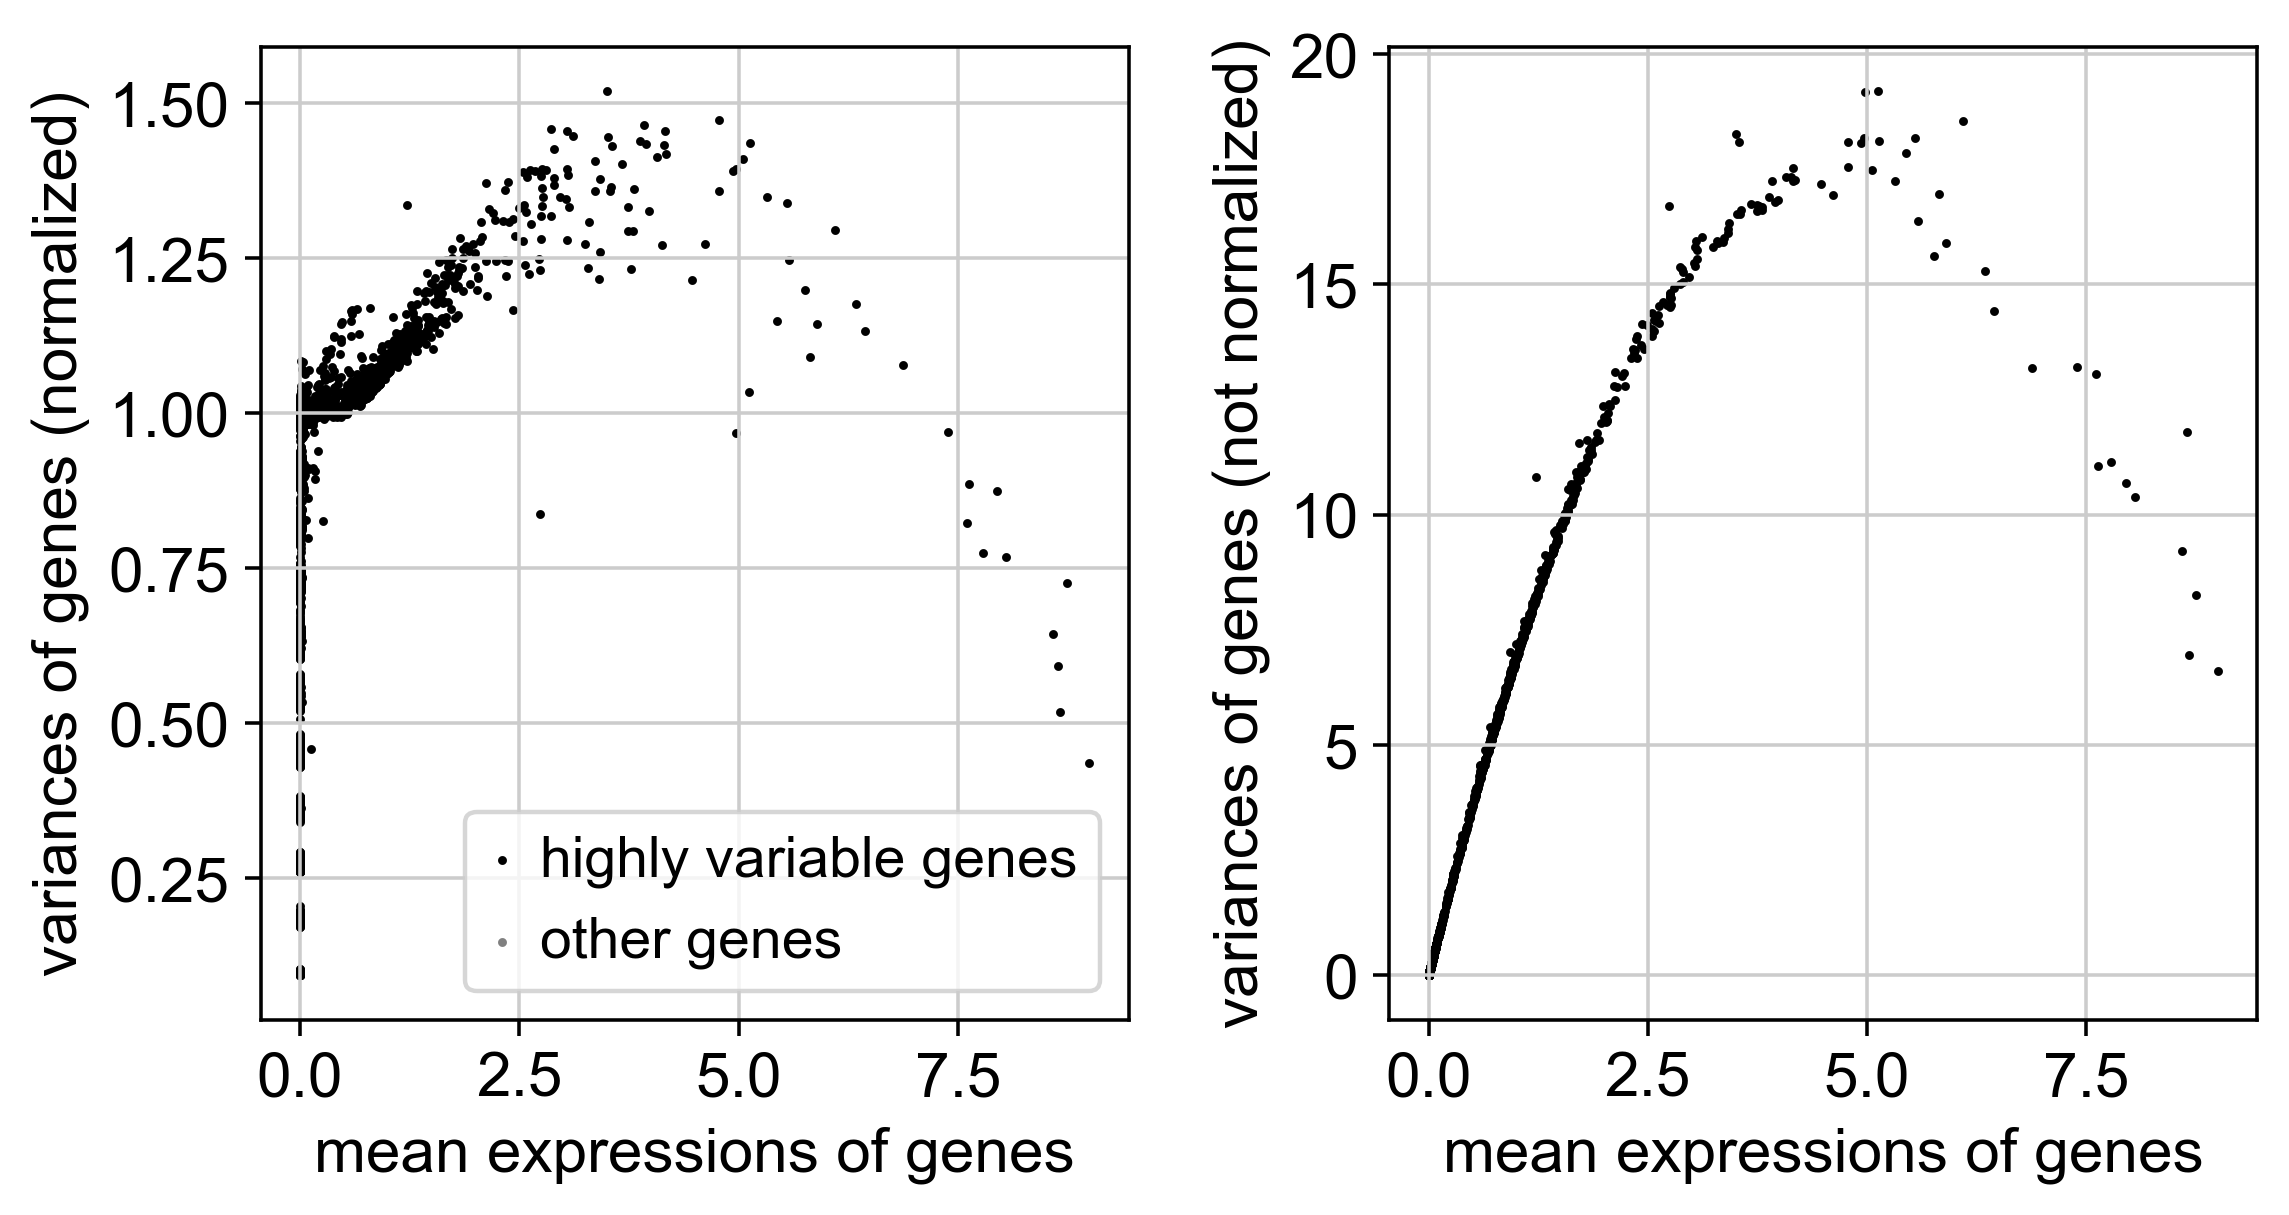

In [8]:
sc.pl.highly_variable_genes(adata)


In [ ]:
# We want to see between 0.25 and 0.75
# This particular pattern either means that the data is garbage or that it is highly significant, caused by disease
# Could see if changing the number of genes from between 4000 to 7000

### Set the raw attribute of the adata object
#### Freezes the state of the adata object


In [ ]:
adata.raw = adata

# Remove this step

### Filtering

In [ ]:
# the actual filtering step
adata = adata[:, adata.var.highly_variable]
#don't need as this was done with the "subset" class

#"regress out effects of total counts per cell and the percentage of mito genes expressed, scale the data to unit variance"
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# This step will also be done using scVI, so remove here (otherwise scVI will generate noise)

In [ ]:
#"Scale each gene to unit variance. Clip values exceeding standard deviation 10"

sc.pp.scale(adata, max_value=10)

#Carlos doesn't do this; scVI will also already do this

### PCA

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
adata

In [ ]:
sc.pl.pca(adata)

# can add covariates here; can remove frames from image

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# This graph would orginally be used to select the number of PCs required for further analysis; no longer important {carlos would not include}

In [ ]:
adata.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qc_plus_visualisation/221201_CaiY2022_MM_PCA_vis')

# not required, can remove

In [ ]:
adata

### Computing neighbourhood graph

In [ ]:
#Values taken from tutorial

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Carlos chooses 50 neighbours, and 50 PCs (taken from elbow graph)
# create the scaffold, UMAP embedding will then place data over scaffold to see how it fits

### UMAP embedding

In [ ]:
# added to avoid error arising from running subsequent cell on its own

#change to leiden

sc.tl.louvain(adata)

In [ ]:
#Code from Scanpy tutorial

sc.tl.paga(adata)

sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

# remove PAGA steps

In [ ]:
#Visualization of adata object, 'color' here can denote specific obs/var/genes
sc.pl.umap(adata)

In [ ]:
adata.var


In [ ]:
# Why have some gene names been swapped with GeneIDs?
# those with changed names are isoforms

In [ ]:
adata.obs

In [ ]:
sc.pl.umap(adata, color='sample')

In [ ]:
# Each sample has made it's own cluster, which is batch effect
# choose variety of covariates from obs for panel

In [ ]:
# Now we can use the following code to plot the scaled and corrected gene expression data

sc.pl.umap(adata, use_raw=False)

### Clustering the neighbourhood graph


In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
adata.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qc_plus_visualisation/221201_CaiY2022_MM_UMAP')
# needs extension .h5ad